In [ ]:
import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt
from sklearn.manifold import SpectralEmbedding
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.datasets import fetch_openml

In [ ]:
from sklearn.datasets import make_s_curve
x_in, y_in = make_s_curve(n_samples=3000,  noise=0.0, random_state=42)

In [ ]:
n_samples, n_features = x_in.shape

In [ ]:
!pip install annoy

In [ ]:
n_neighbors  = 15

In [ ]:
import numpy as np
from annoy import AnnoyIndex
t = AnnoyIndex(n_features, 'euclidean')

for i in range(n_samples):
      t.add_item(i, x_in[i, :])

t.build(10)

knn_indices = []
knn_distances = []
for i in range(n_samples):
    indices, distances = t.get_nns_by_item(i, n_neighbors + 1, include_distances=True)
    knn_indices.append(indices[1:])
    knn_distances.append(distances[1:])

knn_indices = np.array(knn_indices)
knn_distances = np.array(knn_distances)

A = np.zeros((n_samples, n_samples))
rho = knn_distances[:, 0]

In [ ]:
def prob_high_dim(negative_diff_distances_rho_i, sigma):
    return np.exp(negative_diff_distances_rho_i/sigma)

In [ ]:
def sigma_binary_search(negative_diff_distances_rho_i, logK):
    sigma_lower_limit = 0
    sigma_upper_limit = 1000
    for i in range(1000):
        approx_sigma = (sigma_lower_limit + sigma_upper_limit) / 2
        approx_prob = prob_high_dim(negative_diff_distances_rho_i,approx_sigma)
        approx_prob_sum = np.sum(approx_prob)

        if approx_prob_sum < logK:
            sigma_lower_limit = approx_sigma
        else:
            sigma_upper_limit = approx_sigma
        if np.abs(logK - approx_prob_sum) <= 1e-5:
            return approx_sigma

    print("Sigma not found")
    return 1000

In [ ]:
# Compute sigma_i for each point
rho = rho.reshape(rho.shape[0],1)
negative_diff_distances_rho = -np.maximum(0,np.subtract(knn_distances, rho))
log_K = np.log2(n_neighbors)
sigma = np.zeros(n_samples)
for i in range(n_samples):
    sigma[i] = sigma_binary_search(negative_diff_distances_rho[i,:], log_K)

In [ ]:
# Fill the adjacency matrix
A = np.zeros((n_samples, n_samples))
for i in range(n_samples):
    for j in range(n_neighbors):

        index = knn_indices[i,j]
        dist = knn_distances[i,j]
        if dist != 0:
        A[i, index] = np.exp(-max(0, dist - rho[i]) / sigma[i])

<ipython-input-48-02f9c4ba580c>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A[i, index] = np.exp(-max(0, dist - rho[i]) / sigma[i])


In [ ]:
3000*3000-(A==0).sum()

45000

In [ ]:
np.sum((A == 0), axis = 0)

array([2982, 2983, 2984, ..., 2981, 2989, 2985])

In [ ]:
B = A + A.T-np.multiply(A, A.T)

In [ ]:
MIN_DIST = 0.1

x = np.linspace(0, 3, 1000)

def f(x, min_dist):
    y = []
    for i in range(len(x)):
        if(x[i] <= min_dist):
            y.append(1)
        else:
            y.append(np.exp(- x[i] + min_dist))
    return y

dist_low_dim = lambda x, a, b: 1 / (1 + a*x**(2*b))

p , _ = optimize.curve_fit(dist_low_dim, x, f(x, MIN_DIST))

a = p[0]
b = p[1]
print("Hyperparameters a = " + str(a) + " and b = " + str(b))

Hyperparameters a = 1.5768410961320571 and b = 0.894905120661203


In [ ]:
def compute_distances(x):
        n_sample = x.shape[0]
        x_i_norm = np.sum(np.square(x), 1)
        x_dot_prod = np.dot(x, x.T)
        x_j_norm_minus_dot_prod = np.add(-2 * x_dot_prod, x_i_norm).T
        distances = np.add(x_j_norm_minus_dot_prod, x_i_norm)
        # exclude point i from calculation
        distances[range(0, n_sample), range(0, n_sample)] = 0
        return distances

In [ ]:
def prob_low_dim(dij):
    inv_distances = np.reciprocal(1 + a * (dij**b))
    return inv_distances
def CE(P, dij):
    Q = prob_low_dim(dij)
    return - P * np.log(Q + 0.01) - (1 - P) * np.log(1 - Q + 0.01)
def repulsive_grad(y,dij,b, i ,j):
    y_diff = y[i,:] - y[j,:]
    inv_y_dist = prob_low_dim(dij[i,j])
    grad_numerator =  1/(1e-3 + dij[i,j])
    return 2 * b * np.sum(grad_numerator * y_diff * inv_y_dist)
def attractive_grad(y,dij,a,b, i ,j):
    y_diff = y[i,:] - y[j,:]
    inv_y_dist = prob_low_dim(dij[i,j])
    grad_numerator = a * ((1e-8 + dij[i,j])**(b-1))
    return 2 * b * grad_numerator * y_diff * inv_y_dist

In [ ]:
N_LOW_DIMS = 2
LEARNING_RATE = 1
MAX_ITER = 500
N_NEG_SAMPLES = 15

np.random.seed(12345)
#model = SpectralEmbedding(n_components = N_LOW_DIMS, n_neighbors = 15)
#y = model.fit_transform(x_in)
y = np.random.uniform(0, 1, size=(n_samples, n_samples))

In [ ]:
CE_array = []
print("Running Gradient Descent: \n")
dij = compute_distances(y)
for epoch in range(MAX_ITER):
    for i in range(B.shape[0]):
        for j in range(B.shape[1]):
          if np.random.rand() < B[i,j]:
            attractive_grad_i_j = attractive_grad(y,dij,a,b, i,j)
            y[i,:] -= LEARNING_RATE*attractive_grad_i_j
            y[j,:] -= LEARNING_RATE*attractive_grad_i_j
            for _ in range(N_NEG_SAMPLES):
                 k = np.random.randint(0, y.shape[0])
                 y[i,:] -= LEARNING_RATE*repulsive_grad(y,dij,b,i,k)

    dij = compute_distances(y)

    CE_current = np.sum(CE(B, dij)) / 1e+5
    CE_array.append(CE_current)
    if epoch % 10 == 0:
        print("Cross-Entropy = " + str(CE_current) + " after " + str(epoch) + " iterations")

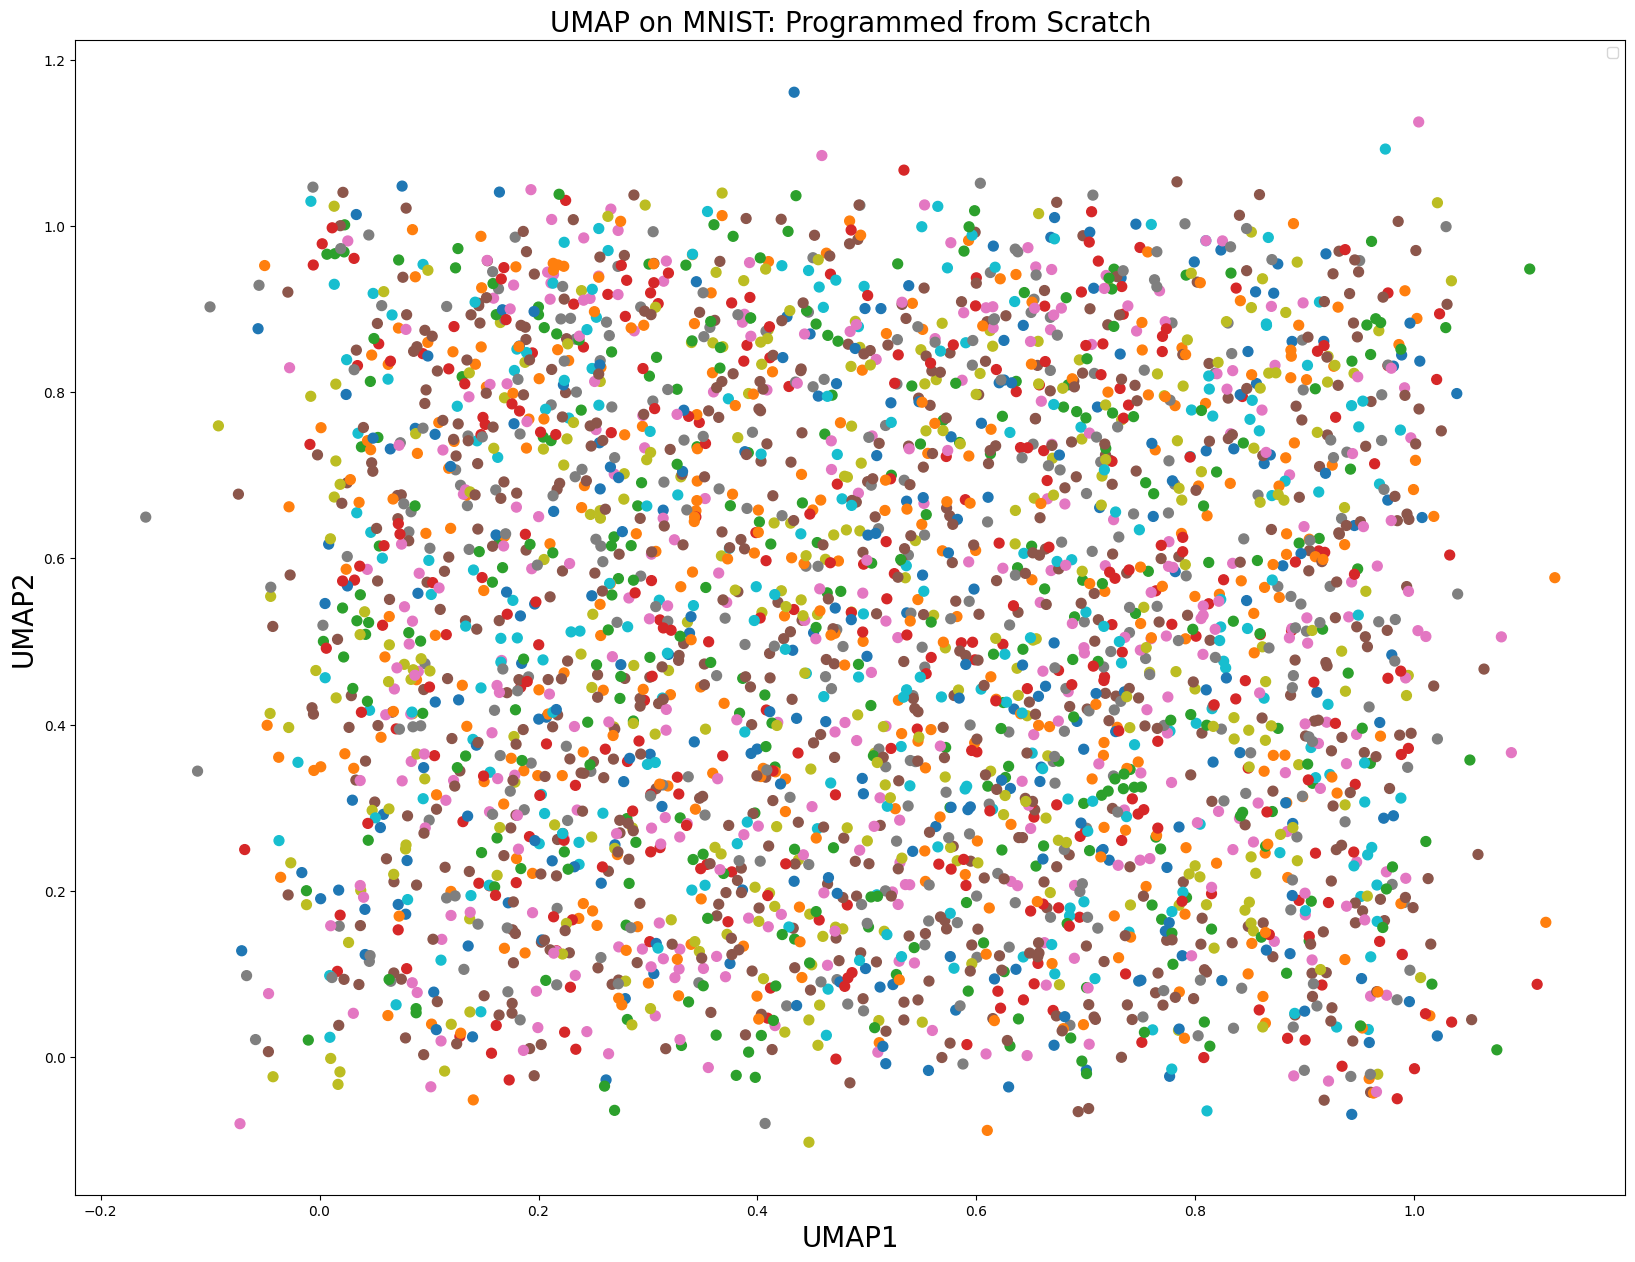

In [ ]:
plt.figure(figsize=(20,15))
plt.scatter(y[:,0], y[:,1], c = y_in.astype(int), cmap = 'tab10', s = 50)
plt.title("UMAP on MNIST: Programmed from Scratch", fontsize = 20)
plt.xlabel("UMAP1", fontsize = 20); plt.ylabel("UMAP2", fontsize = 20)
plt.legend()
plt.show()